In [66]:
import os
import cv2
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [6]:
def Load_data():
    # Load the data
    # Path: data_processing.ipynb
    # Return: data, label
    Vectors = np.loadtxt('./digits4000_txt/digits4000_txt/digits4000_digits_vec.txt')
    Labels = np.loadtxt('./digits4000_txt/digits4000_txt/digits4000_digits_labels.txt').reshape(-1,1)
    # train_X,test_X,train_y,test_y = train_test_split(Vectors, Labels, test_size=0.5)
    return Vectors, Labels

In [25]:
def Trans_data2img(x_img):
    # transform the nparray into cv image in gray
    image = Image.fromarray(x_img.reshape(28,28).astype(np.uint8))
    img = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2BGR)
    return img


def SIFT_extraction(img, threshold):
    sift = cv2.SIFT_create(threshold)
    kps, features = sift.detectAndCompute(img, None)
    return features

def Learn_vocabulary(features, K=150):
    # K is number of the clusters
    #set the convergence criteria for kmeans
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
    #set the initail centroids for kmeans
    flags = cv2.KMEANS_RANDOM_CENTERS

    compactness, labels, centroids = cv2.kmeans(features, int(K), None, criteria, 10, flags)
    return centroids


def Set_centroids(X, threshold, K=150):
    features = []
    for x_img in X:
        img = Trans_data2img(x_img)
        # extract the SIFT features
        img_features = SIFT_extraction(img, threshold)
        if img_features is not None:
            features.append(img_features)
    features = np.vstack(features)

    #learn the centroids by kmeans
    centroids = Learn_vocabulary(features, K)
    # save the centroids for training
    filename = "./SIFT_FX/SIFT_centroids.npy"
    np.save(filename, centroids)
    print('vocabular package:',centroids.shape)
    return centroids

def Get_featureVec(features, centers, K=150):
    featureVec = np.zeros((1, K))
    for feature in features:
        feature = np.float32(feature)
        index = (np.sum((centers - feature) ** 2, axis=1)).argmin()
        featureVec[0][index] += 1
    return featureVec

def Get_Vecs_from_SIFT(X, y, threshold, K=150):
    centroids = np.load('./SIFT_FX/SIFT_centroids.npy')
    SIFT_vecs = []
    labels = []
    for i in range(X.shape[0]):
        img = Trans_data2img(X[i])
        # extract the SIFT features
        img_features = SIFT_extraction(img, threshold)
        # get the feature vector
        if img_features is not None:
            img_vec = Get_featureVec(img_features, centroids, K)
            SIFT_vecs.append(img_vec)
            labels.append(y[i])
    SIFT_vecs = np.vstack(SIFT_vecs)
    print('data_vec:',SIFT_vecs.shape)
    print('image features vector done!')
    return SIFT_vecs, labels   

In [103]:
X,y = Load_data()
threshold = 25
Set_centroids(X, threshold, K=150)
SIFT_vecs, labels = Get_Vecs_from_SIFT(X, y, threshold, K=150)

vocabular package: (150, 128)
data_vec: (3921, 150)
image features vector done!


In [90]:

X_train, X_test, y_train, y_test = train_test_split(SIFT_vecs, labels, test_size=0.5)


In [92]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
t1 = time.time()
clf = SVC()
print(X_train.shape)
clf.fit(X_train, np.array(y_train).ravel())
t2 = time.time()
preds = clf.predict(X_test)
print('Accuracy = {}'.format(accuracy_score(y_test, preds)))
print('Time taken = {} sec'.format(t2-t1))

(1960, 150)
Accuracy = 0.717491075981642
Time taken = 0.24167609214782715 sec


In [95]:
def tune_parameters(X_train, y_train):

	# t1 = time.time()
	# clf = SVC(kernel='rbf')
	# print(X_train.shape)
	# clf.fit(X_train, np.array(y_train).ravel())
	# t2 = time.time()
	# preds = clf.predict(X_test)
	# print('Accuracy = {}'.format(accuracy_score(y_test, preds)))
	# print('Time taken = {} sec'.format(t2-t1))
	parameters = [
		{
			'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
			'gamma': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000],
			'kernel': ['rbf']
		},
		{
			'C': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
			'kernel': ['linear']ssssss
		}
	]

	svc = SVC()
	clf = GridSearchCV(svc, parameters, cv=3, n_jobs=8)
	clf.fit(X_train, y_train)

	print("The best parameters are %s with a score of %0.2f"
		% (clf.best_params_, clf.best_score_))

	scores = clf.cv_results_['mean_test_score'][0:80].reshape(8,10)

	plt.figure(figsize=(8, 6))
	plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
	plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
	plt.xlabel('gamma')
	plt.ylabel('C')
	plt.colorbar()
	plt.xticks(np.arange(8), [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000], rotation=45)
	plt.yticks(np.arange(10), [1, 3, 5, 7, 9, 11, 13, 15, 17, 19])
	plt.title('RBF Validation accuracy')
	plt.show()

	clf = SVC(C=clf.best_params_['C'], gamma=clf.best_params_['gamma'], kernel=clf.best_params_['kernel'])
	clf.fit(X_train, y_train)
	return clf


c:\Users\huancwang2\.conda\envs\regular\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best parameters are {'C': 1, 'kernel': 'linear'} with a score of 0.90


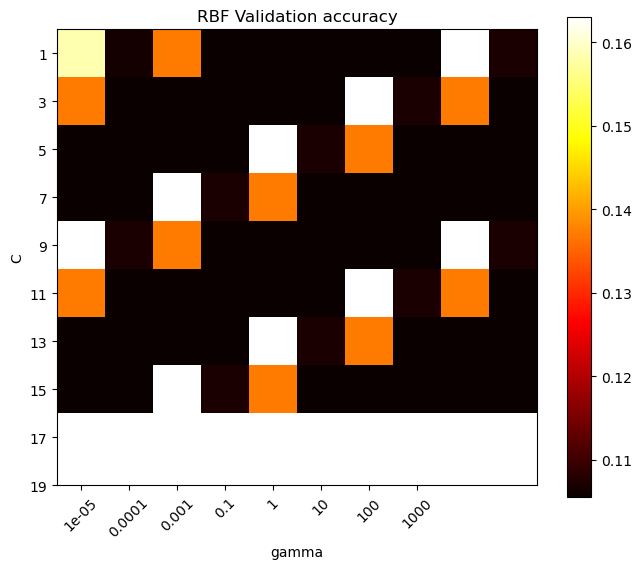

KeyError: 'gamma'

In [96]:
clf = tune_parameters(X_train, y_train)
preds = clf.predict(X_test)
print('Accuracy = {}'.format(accuracy_score(y_test, preds)))

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)
t1 = time.time()
clf = SVC()
print(X_train.shape)
clf.fit(X_train, np.array(y_train).ravel())
t2 = time.time()
preds = clf.predict(X_test)
print('Accuracy = {}'.format(accuracy_score(y_test, preds)))
print('Time taken = {} sec'.format(t2-t1))

(2000, 784)
Accuracy = 0.936
Time taken = 0.2740952968597412 sec
